#  Binary Table Basics with Astropy
If you're not familiar, this is a Jupyter Notebook, a sort of Python-powered interactive document. Jupyter notebooks are made up of cells which can contain Python code or Markdown (like this cell). The cells can each be executed individually.

In [43]:
# Imports
import numpy as np

# Astropy
from astropy.io import fits
from astropy.table import Column, Table

# Pandas (for DataFrames)
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Magically make plots appear in the notebook
%matplotlib inline

# Change this to point to the directory containing the M83 data products
# for today's examples, if you didn't download and unzip them in this directory.
data_path = 'M83/'

## Binary Table I/O
Catalogs and X-ray data products are often distributed as binary (i.e., not human readable) tables. Commonly we use the `.fits` format for this. We have a couple ways of loading these files in a Python script. This is nowhere near an exhaustive tutorial, just some notes to give you an idea of how we use these things.

### Low-level interface: `astropy.io.fits`
This is the basic Astropy interface for `.fits` files, including images, as we'll see below.

In [7]:
hdul = fits.open(data_path + 'M83-final-sample.fits')

Fits files are organized as a series of headers, each of which can have
a binary dataset attached. By default fits.open returns a list of all of these
header+data units (HDUs), which it calls an HDUList.

In [9]:
hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff25208a400>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff252096908>]

We can see that this list for this binary table file has two elements: a `PrimaryHDU` object (which is typically but not always empty), and a `BinTableHDU` which contains the header and data for the catalog. 

Each of these HDU objects has a `header` and a `data` property. First we'll confirm there's nothing in the first HDU:

In [16]:
hdul[0].header

SIMPLE  =                    T /Dummy Created by MWRFITS v1.13                  
BITPIX  =                    8 /Dummy primary header created by MWRFITS         
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               

In [18]:
print(hdul[0].data)

None


In the second, the header contains the description of the table, including how many rows it has and what all the columns are named. The amount of information you get here depends on where you got the table; it can sometimes include information on the units of the columns, though this is not mandatory.

In [21]:
hdul[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.13           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  754 /Number of bytes per row                         
NAXIS2  =                  528 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   70 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

When we load tables this way, the data comes in as a structured NumPy array. We can access the columns with an `array['COLNAME']` syntax.

In [28]:
M83_catalog = hdul[1].data

names = M83_catalog['NAME']
NH = M83_catalog['NH']
gamma = M83_catalog['GAMMA']

# We'll print out the ID, NH, and Gamma of the
# first 10 sources in the catalog 
for s, n, g in zip(names[:10], NH[:10], gamma[:10]):
    print('%s    %6.4f   %5.3f' % (s,n,g)) # These are C-style format codes

133623.18-295516.7    0.1063   1.402
133624.28-295402.1    0.2510   1.663
133626.81-295535.9    0.0900   1.786
133626.82-295309.2    0.0900   1.817
133628.84-295717.8    0.2383   1.478
133629.04-295538.9    0.1271   1.684
133629.06-295123.4    6.1940   2.020
133631.69-295710.0    0.0900   2.011
133633.27-295717.9    0.0370   1.700
133633.57-300013.5    1.1830   2.458


All the data is there, and we can access it and use it as we want. However, it's not necessarily easy to look at. That brings us to:

### Higher-level interface: `astropy.table.Table`
The Astropy Table class glosses over a few of the above steps for us, and gives us a slightly nicer interface to tables. It also works for ascii tables. With the table interface we need only do

In [29]:
M83_table = Table.read(data_path + 'M83-final-sample.fits')

The Table class assumes that the table is in the second HDU, so we can skip all the HDUList stuff. Note that you can, however, specify a specific HDU with the `hdu` keyword argument to `Table.read()`. This method doesn't get us the original FITS header, but the Table object we get back from `Table.read()` contains some of the information.

In [35]:
M83_table.info

<Table length=528>
         name          dtype  shape n_bad
--------------------- ------- ----- -----
                 NAME bytes18           0
                   ID   int16           0
                   RA float64           0
                  DEC float64           0
                   DL float64           0
             PSF_FRAC float32           0
             OFF_AXIS float32           0
             NET_CNTS float32  (3,)     0
         NET_CNTS_ERR float32  (3,)     0
             EXPOSURE float32           0
                CSTAT float64           2
                  DOF   int32           0
               NH_GAL float64           2
                   NH float64           4
               NH_ERR float64           4
                GAMMA float32           2
            GAMMA_ERR float32           2
                  FH2 float64           2
                  F28 float64           2
                  FH8 float64           2
                  LH2 float64           2
               

From the 'shape' column in the above, it's somewhat easier (compared to the raw FITS header) to see that some of our columns are actually vector-valued. The `NET_CNTS` columns have 3 values for every row, and most of the columns from ACISExtract (`AE_*`) have 11.

The `Table` interface gives us a nicer way to access and look at the table, too:

In [36]:
M83_table['NAME', 'NH', 'GAMMA'][:10] # the [:10] gives us just the first 10 rows

NAME,NH,GAMMA
bytes18,float64,float32
133623.18-295516.7,0.1063,1.402
133624.28-295402.1,0.251,1.663
133626.81-295535.9,0.09,1.786
133626.82-295309.2,0.09,1.817
133628.84-295717.8,0.2383,1.478
133629.04-295538.9,0.1271,1.684
133629.06-295123.4,6.194,2.02
133631.69-295710.0,0.09,2.011
133633.27-295717.9,0.037,1.7


we can give multiple comma-separated column names to get a subset of the columns in the table. Adding columns is also pretty easy:

In [44]:
zeros = np.zeros(len(M83_table)) # An array of zeros as long as the table
zero_col = Column(data=zeros, name='ZERO') # Copy the array into an astropy.table.Column object
M83_table.add_column(zero_col)

In [45]:
M83_table.info

<Table length=528>
         name          dtype  shape n_bad
--------------------- ------- ----- -----
                 NAME bytes18           0
                   ID   int16           0
                   RA float64           0
                  DEC float64           0
                   DL float64           0
             PSF_FRAC float32           0
             OFF_AXIS float32           0
             NET_CNTS float32  (3,)     0
         NET_CNTS_ERR float32  (3,)     0
             EXPOSURE float32           0
                CSTAT float64           2
                  DOF   int32           0
               NH_GAL float64           2
                   NH float64           4
               NH_ERR float64           4
                GAMMA float32           2
            GAMMA_ERR float32           2
                  FH2 float64           2
                  F28 float64           2
                  FH8 float64           2
                  LH2 float64           2
               

In [46]:
M83_table['NAME', 'NH', 'GAMMA', 'ZERO'][:10] # the [:10] gives us just the first 10 rows

NAME,NH,GAMMA,ZERO
bytes18,float64,float32,float64
133623.18-295516.7,0.1063,1.402,0.0
133624.28-295402.1,0.251,1.663,0.0
133626.81-295535.9,0.09,1.786,0.0
133626.82-295309.2,0.09,1.817,0.0
133628.84-295717.8,0.2383,1.478,0.0
133629.04-295538.9,0.1271,1.684,0.0
133629.06-295123.4,6.194,2.02,0.0
133631.69-295710.0,0.09,2.011,0.0
133633.27-295717.9,0.037,1.7,0.0


If the data we had added were actually useful, we could save the table using
```
M83_table.write(data_path + 'M83-final-sample_withzeros.fits')
```
to make a new copy or
```
M83_table.write(data_path + 'M83-final-sample.fits', overwrite=True)
```
to overwrite the existing table.

### Using Table Data and Creating Tables
Finally, an example or two to show how you can use binary tables in practice.

Suppose we want to operate on just a subset of sources with small off-axis angles, $<7.5'$ (completely arbitrarily):

In [56]:
mask = M83_table['OFF_AXIS'] <= 7.5 # This is a boolean (i.e. True/False, 1/0) array
print(np.count_nonzero(mask))

505


Seems like there are 505 of these, out of an original 528. When we index the table by our mask, only the rows where `mask == True` are returned:

In [57]:
M83_subset = M83_table[mask]
print(M83_subset.info)

<Table length=505>
         name          dtype  shape n_bad
--------------------- ------- ----- -----
                 NAME bytes18           0
                   ID   int16           0
                   RA float64           0
                  DEC float64           0
                   DL float64           0
             PSF_FRAC float32           0
             OFF_AXIS float32           0
             NET_CNTS float32  (3,)     0
         NET_CNTS_ERR float32  (3,)     0
             EXPOSURE float32           0
                CSTAT float64           2
                  DOF   int32           0
               NH_GAL float64           2
                   NH float64           4
               NH_ERR float64           4
                GAMMA float32           2
            GAMMA_ERR float32           2
                  FH2 float64           2
                  F28 float64           2
                  FH8 float64           2
                  LH2 float64           2
               

But we get all the original columns. From here, you can probably start to see how you might use the same sort of syntax to select only significant detections, or sources with certain power law slopes. You can combine arbitrarily many selections with logical operations to select only certain rows.

Just to have something to do, suppose we want to calculate some X-ray colors from the net counts for the subset of sources we just selected. There'll be some (many) complaints from Python here as we divide by 0 and take the log of 0, but we'll ignore them.

In [69]:
net_S = M83_subset['NET_CNTS'][:,0]
net_M = M83_subset['NET_CNTS'][:,1]
net_H = M83_subset['NET_CNTS'][:,2]

MS = np.log10(net_M / net_S)
HM = np.log10(net_H / net_M)
HS = np.log10(net_H / net_S)

MS[~np.isfinite(MS)] = np.nan
HM[~np.isfinite(HM)] = np.nan
HS[~np.isfinite(HS)] = np.nan

/Users/Erik/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/Erik/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/Erik/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/Erik/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Erik/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/Erik/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/Erik/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_lau

We'll make a new table to hold these colors:

In [70]:
M83_subset_colors = Table() # empty table

# We can add column just by indexing
# the table by the column name we want,
# *as long as the column lengths are the same*
M83_subset_colors['NAME'] = M83_subset['NAME']
M83_subset_colors['logMS'] = MS
M83_subset_colors['logHM'] = HM
M83_subset_colors['logHS'] = HS


M83_subset_colors[:10]

NAME,logMS,logHM,logHS
bytes18,float32,float32,float32
133634.85-295436.9,nan,nan,nan
133636.00-295118.3,-0.24966022,-0.10964115,-0.35930136
133636.78-295019.4,-0.18863736,-0.2644293,-0.45306668
133637.45-295410.2,-0.3787546,0.14362791,-0.23512669
133637.69-295235.8,-0.15733737,-0.35991135,-0.51724875
133638.13-295512.9,-0.27531993,nan,nan
133638.57-295553.5,-0.21018037,-0.20587191,-0.41605228
133640.09-295429.6,-0.41177157,0.19890498,-0.21286656
133640.55-295455.2,-0.60571253,0.4819845,-0.12372803


Plot the colors from the table:

Text(0, 0.5, '$\\log~(\\rm H / M)$')

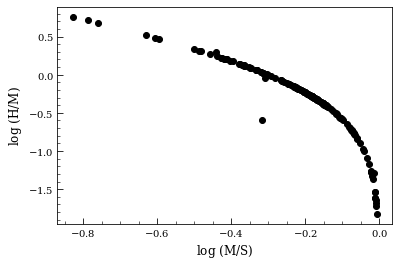

In [72]:
fig, ax = plt.subplots()

ax.plot(M83_subset_colors['logMS'],
        M83_subset_colors['logHM'],
        marker='o',
        color='k',
        markerfacecolor='k',
        linestyle='')

ax.set_xlabel(r'$\log~(\rm M / S)$')
ax.set_ylabel(r'$\log~(\rm H / M)$')

And save the new table:

In [75]:
M83_subset_colors.write(data_path + 'M83-subset-colors.fits', overwrite=True)

### Further reading
- https://docs.astropy.org/en/stable/io/fits/index.html
- https://docs.astropy.org/en/stable/table/index.html